# Check ToM ROIs
Natalia Vélez, February 2022

In [82]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
from nilearn import image,plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from os.path import join as opj

sys.path.append('..')
from utils import gsearch

sns.set_style('white')
sns.set_context('talk')

Make output directory:

In [2]:
out_dir = 'outputs/roi_picker'
os.makedirs(out_dir, exist_ok=True)

Find ROI files:

In [3]:
data_dir = '../../BIDS_data/derivatives/'
roi_dir = opj(data_dir, 'roi_picker')

roi_files = gsearch(roi_dir, '**', 'func', '*.nii.gz')
roi_files.sort()

print('Found %i ROI files' % len(roi_files))
print(*roi_files[:10], sep='\n')

Found 194 ROI files
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-DMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-LTPJ_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-MMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-PC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RSTS_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RTPJ_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-VMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-02/func/sub-02_task-tomloc_model-localizer_desc-DMPFC_mask.nii.gz
../../BIDS_data/derivatives/roi_picker/sub-02/func/sub-02_task-tomloc_model-localizer_desc-LTPJ_mask.nii.gz
../../

## Tally functional ROIs

Tally files

In [4]:
roi_df = pd.DataFrame({'path': roi_files})
roi_df['subject'] = roi_df.path.str.extract('(sub-[0-9]{2})')
roi_df['roi'] = roi_df.path.str.extract('(?<=desc-)([A-Z]+)')
roi_df.head()

,path,subject,roi
0,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,DMPFC
1,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,LTPJ
2,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,MMPFC
3,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,PC
4,../../BIDS_data/derivatives/roi_picker/sub-01/...,sub-01,RSTS


Did all participants run successfully?

In [5]:
roi_df['subject'].agg('nunique')

28

How many participants have each ROI?

In [6]:
roi_df.groupby('roi').agg({'subject': 'nunique'})

,subject
roi,
DMPFC,28
LTPJ,28
MMPFC,27
PC,28
RSTS,28
RTPJ,28
VMPFC,27


Who's missing ROIs?

In [7]:
roi_pivot = roi_df.groupby(['subject', 'roi']).size().unstack(fill_value=0).astype(bool)
roi_pivot[~roi_pivot.all(axis=1)]

roi,DMPFC,LTPJ,MMPFC,PC,RSTS,RTPJ,VMPFC
subject,,,,,,,
sub-11,True,True,False,True,True,True,False


## Check ROI location and extent

Plot locations and extent of each ROI:

/n/home_fasse/nvelezalicea/.conda/envs/py3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/home_fasse/nvelezalicea/.conda/envs/py3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/n/home_fasse/nvelezalicea/.conda/envs/py3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

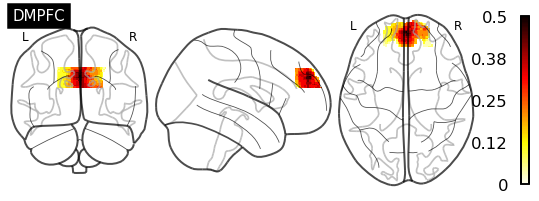

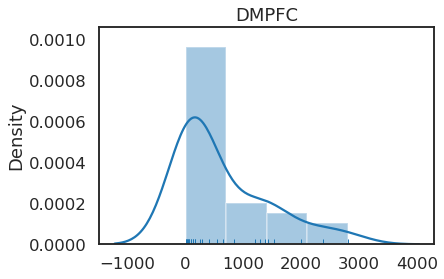

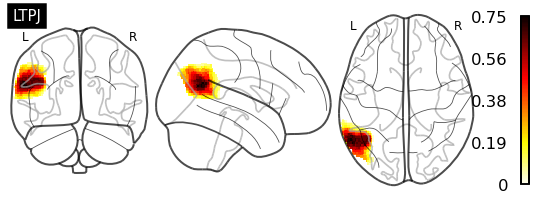

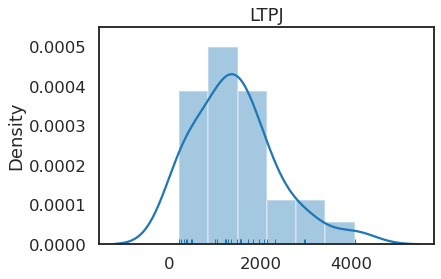

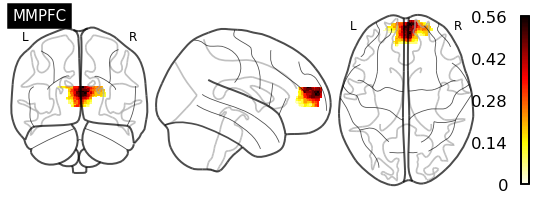

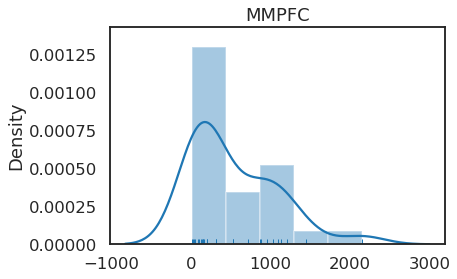

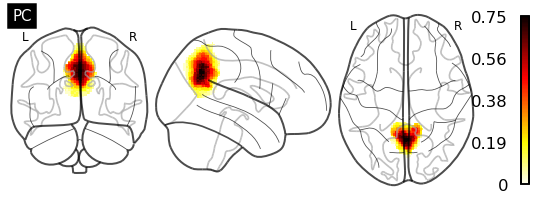

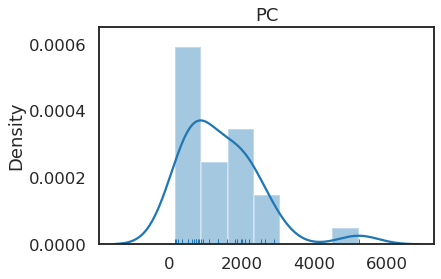

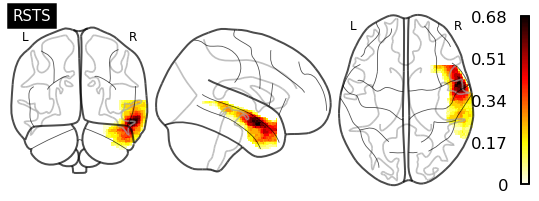

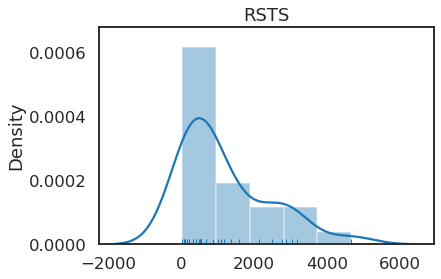

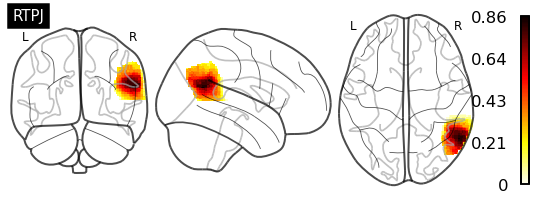

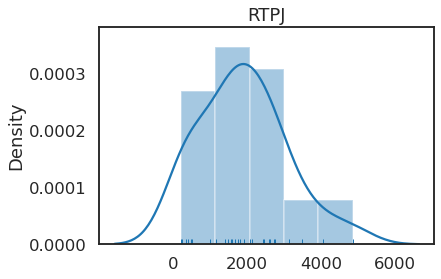

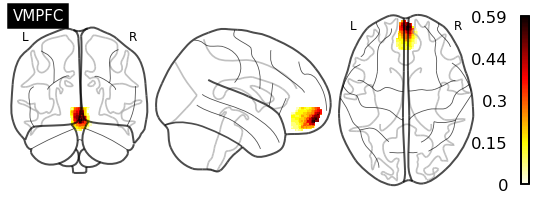

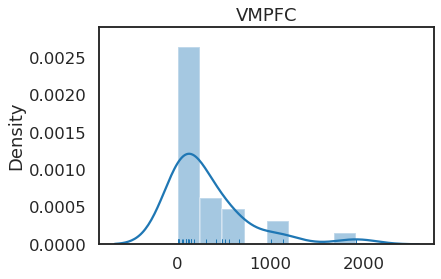

In [8]:
extent_list = []

for name, group in roi_df.groupby('roi'):
    # Load all ROI images
    roi_images = image.load_img(group.path.values.tolist())

    # Plot mean ROI
    mean_roi = image.mean_img(roi_images)
    mean_roi_plot = plotting.plot_glass_brain(mean_roi, colorbar=True, title=name)
    mean_roi_plot.savefig(opj(out_dir, '%s_location.png' % name))

    # Get ROI extent
    roi_extents = np.apply_over_axes(np.sum, roi_images.dataobj, range(roi_images.dataobj.ndim - 1)).flatten()
    roi_extents_df = group.copy()
    roi_extents_df['extent'] = roi_extents
    extent_list.append(roi_extents_df)

    fig,ax=plt.subplots()
    sns.distplot(roi_extents, rug=True, ax=ax)
    ax.set(title=name)
    plt.savefig(opj(out_dir, '%s_extent.png' % name))

Put together dataframe of ROI extents

In [9]:
all_roi_extents = pd.concat(extent_list)
all_roi_extents.to_csv(opj(out_dir, 'all_roi_extents.csv'), index=False)
all_roi_extents.groupby('roi').agg({'extent': ['min', 'max', 'median']})

extent                
         min     max  median
roi                         
DMPFC   11.0  2815.0   220.0
LTPJ   215.0  4067.0  1326.0
MMPFC   16.0  2151.0   308.0
PC     172.0  5231.0  1229.5
RSTS    46.0  4667.0   619.5
RTPJ   220.0  4858.0  1789.0
VMPFC   12.0  1914.0   154.0

## Demo: Plot all ROIs for a representative participant

Define color palette:

Load ACCg:

(114, 135, 114)


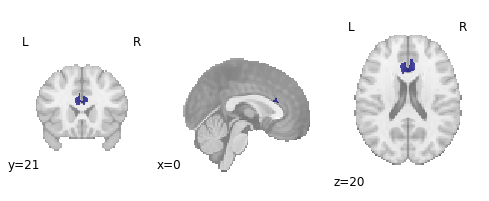

In [21]:
acc_file = '/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/fmriprep_space/bilateral_ACCg.nii.gz'
acc_image = image.load_img(acc_file)
acc_data = acc_image.get_fdata()

print(acc_data.shape)
plotting.plot_roi(acc_image, draw_cross=False)

Select participant's data:

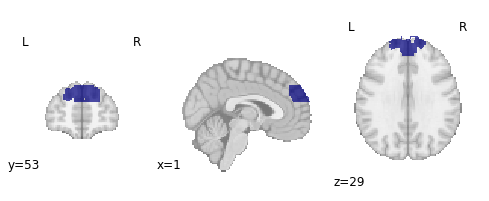

In [64]:
# get all participant ROIs
sub = 'sub-02'
sub_roi = roi_df[roi_df.subject == sub]

# load all images
sub_images = [image.load_img(f) for f in sub_roi.path]
sub_data = [img.get_fdata() for img in sub_images]
plotting.plot_roi(sub_images[0], draw_cross=False) # example roi

Putting everything together:

In [65]:
# put together all images
all_roi_data = np.array([acc_data] + sub_data)
print(all_images.shape)

# aggregate
atlas_data = np.zeros(all_roi_data.shape[1:])
for idx in range(all_roi_data.shape[0]):
    roi = all_roi_data[idx,:,:]
    roi_val = idx+1
    
    atlas_data[roi > 0] = roi_val
    
atlas_img = image.new_img_like(acc_image, atlas_data)

(8, 114, 135, 114)


Plot atlas

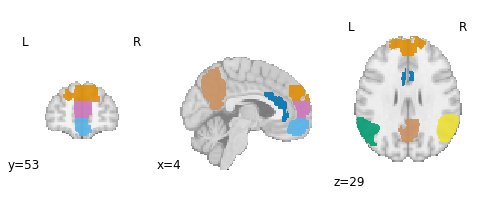

In [91]:
roi_colors = sns.color_palette('colorblind', all_roi_data.shape[0], as_cmap=True)
roi_cmap = colors.ListedColormap(roi_colors)
plotting.plot_roi(atlas_img, draw_cross=False, cut_coords=[4, 53, 29], cmap=roi_cmap, alpha=0.9)
plt.savefig('plots/sample_roi_slice1.png')

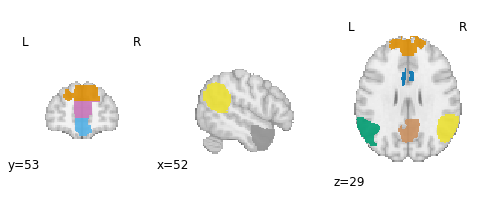

In [90]:
plotting.plot_roi(atlas_img, draw_cross=False, cut_coords=[52, 53, 29], cmap=roi_cmap, alpha=.9)
plt.savefig('plots/sample_roi_slice2.png')

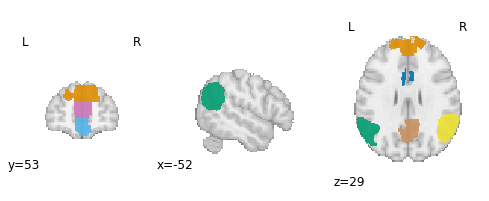

In [89]:
plotting.plot_roi(atlas_img, draw_cross=False, cut_coords=[-52, 53, 29], cmap=roi_cmap, alpha=.9)